# EN4 RAPID-OSNAP into T/S space

In [59]:
# import sys
# sys.path.append('/Users/dge105/Dropbox/Python_modules')

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib
import datetime
import numpy as np
import cmocean
import pickle
import gsw
import seawater as sw
import numpy_groupies as npg
import cartopy.crs as ccrs
import os

from wmt import bin_3D_field_2D
from wmt import calc_tot_trans
from wmt import calc_grid_vol

from sklearn import preprocessing
from sklearn import mixture

from matplotlib import gridspec
from matplotlib import cm

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Load RG Argo data
Data extracted and saved within ~/Dropbox/work_general/datasets/RG_Argo/RG_Argo_extract.ipynb

In [3]:
lon_limits = [275, 355]
lat_limits = [25, 60]

dset_dir = os.path.expanduser('~/Dropbox/work_general/datasets/EN4/*.nc')
dset = xr.open_mfdataset(dset_dir)
# dset = dset.sel(lon=((dset.lon<20) | (dset.lon>275)), lat=slice(lat_limits[0],lat_limits[1]))
dset = dset.sel(lon=((dset.lon>275) & (dset.lon<355)), lat=slice(lat_limits[0],lat_limits[1]), time=dset.time>np.datetime64('2004-01-01'))

m_dats = mdates.date2num(dset.time)

In [4]:
# Load basin mask
# mask_dir = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
# mask = xr.open_dataset(mask_dir)

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


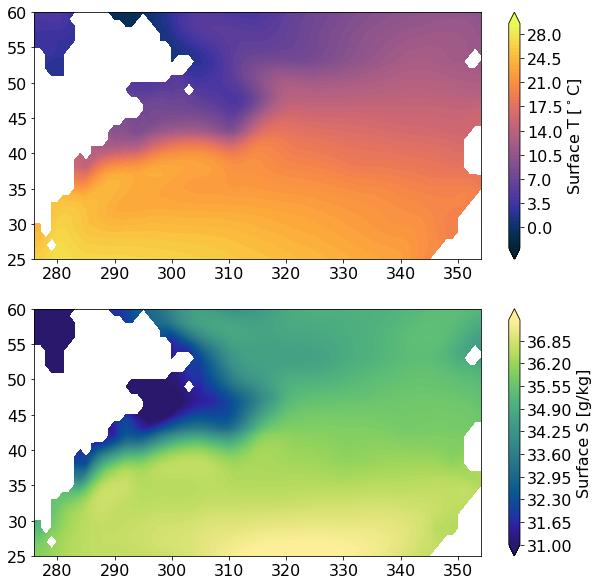

In [5]:
fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

T_levels = np.arange(-3, 30, 0.5) 
S_levels = np.arange(31, 37.5, 0.05) 

CS_T = ax1.contourf(dset.lon, dset.lat, np.nanmean(dset.temperature[:, 0, :, :], axis=0) - 273.15,
           T_levels, cmap=cmocean.cm.thermal, extend='both')

CS_S = ax2.contourf(dset.lon, dset.lat, np.nanmean(dset.salinity[:, 0, :, :], axis=0),
           S_levels, cmap=cmocean.cm.haline, extend='both')

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Surface T [$^\circ$C]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('Surface S [g/kg]')

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_surfTS.png'), dpi=300, bbox_inches='tight')


In [6]:
lat = dset.lat.data
lon = dset.lon.data
dep = dset.depth.data
max_dep = dep[-1] + np.diff(dep)[-1]

gr_vol = calc_grid_vol(lon, lat, dep, 'm', 0, max_dep)

In [7]:
lon_g, lat_g = np.meshgrid(lon, lat)

lon_g = np.moveaxis(np.repeat(np.expand_dims(lon_g, axis=2), len(dep), axis=2), [2], [0])
lat_g = np.moveaxis(np.repeat(np.expand_dims(lat_g, axis=2), len(dep), axis=2), [2], [0])
dep_g = np.moveaxis(np.tile(dep, (np.shape(lat_g)[2], np.shape(lat_g)[1], 1)), [0, 1, 2], [2, 1, 0])


### Loop through each time-step

In [8]:
dS = 0.025
dT = 0.25
# S_bin = np.arange(32, 38 + dS, dS)
S_bin = np.arange(25, 40 + dS, dS)
T_bin = np.arange(-3, 32 + dT, dT)
S_bini = S_bin[0:-1] + dS/2
T_bini = T_bin[0:-1] + dT/2 
S_binii = S_bini[0:-1] + dS/2
T_binii = T_bini[0:-1] + dT/2 

In [155]:
lon_g, lat_g = np.meshgrid(dset.lon, dset.lat)
lon_g = np.repeat(np.expand_dims(lon_g, axis=0), len(dset.depth), axis=0)
lat_g = np.repeat(np.expand_dims(lat_g, axis=0), len(dset.depth), axis=0)
pres_g = np.moveaxis(np.tile(dset.depth, (np.shape(lon_g)[2], np.shape(lon_g)[1], 1)), [0, 1, 2], [2, 1, 0])

ts_vol = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lat = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lon = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_dep = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))

bin_edge1 = T_bin
bin_edge2 = S_bin
# func = 'sum'

for ii in np.arange(0, np.shape(dset.temperature)[0], 1):

    SA = gsw.SA_from_SP(dset.salinity[ii, :, :, :], pres_g, lon_g, lat_g)
    CT = gsw.CT_from_t(SA, dset.temperature[ii, :, :, :] - 273.15, pres_g)

    bin1_3D = CT
    bin2_3D = SA
    var_3D = gr_vol

    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'sum')
    ts_vol[:, :, ii] = out[0]
    
    var_3D = lon_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lon[:, :, ii] = out[0]

    var_3D = lat_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lat[:, :, ii] = out[0]
    
    var_3D = dep_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_dep[:, :, ii] = out[0]
    
# ts_vol[ts_vol == 0] = np.nan
    
ts_vol = {'ts_vol': ts_vol, 'S_bini': S_bini, 'T_bini': T_bini, 'S_binii': S_binii, 'T_binii': T_binii, 'time': m_dats}
    

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


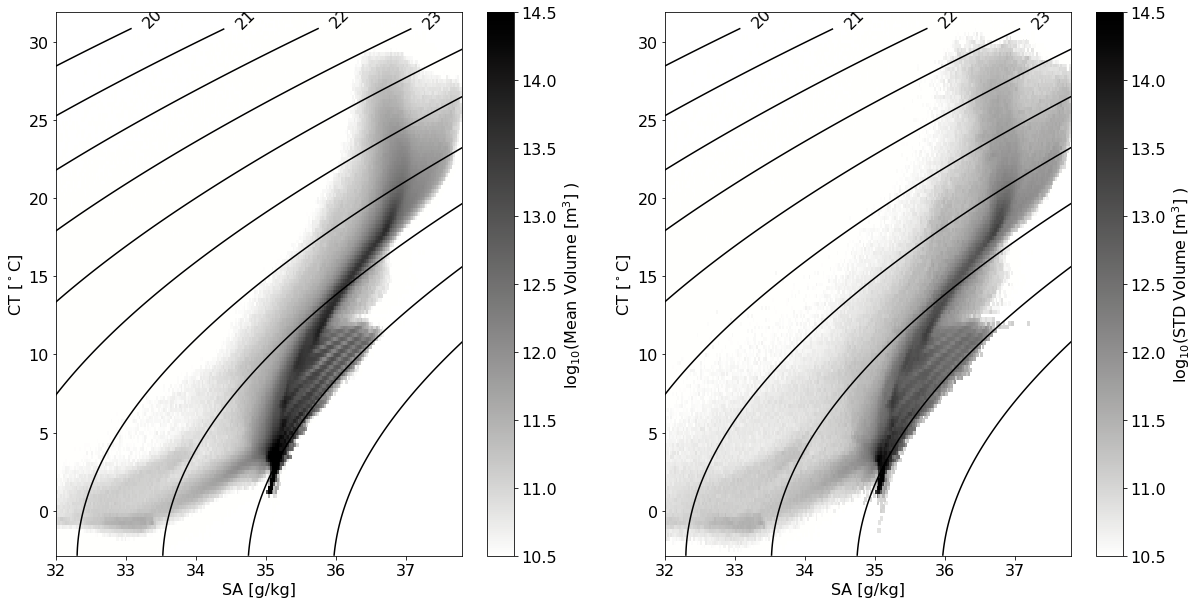

In [10]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, np.log10(np.nanstd(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('log$_{10}$(STD Volume [m$^3$] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_vol_mean_std.png'), dpi=300, bbox_inches='tight')


/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


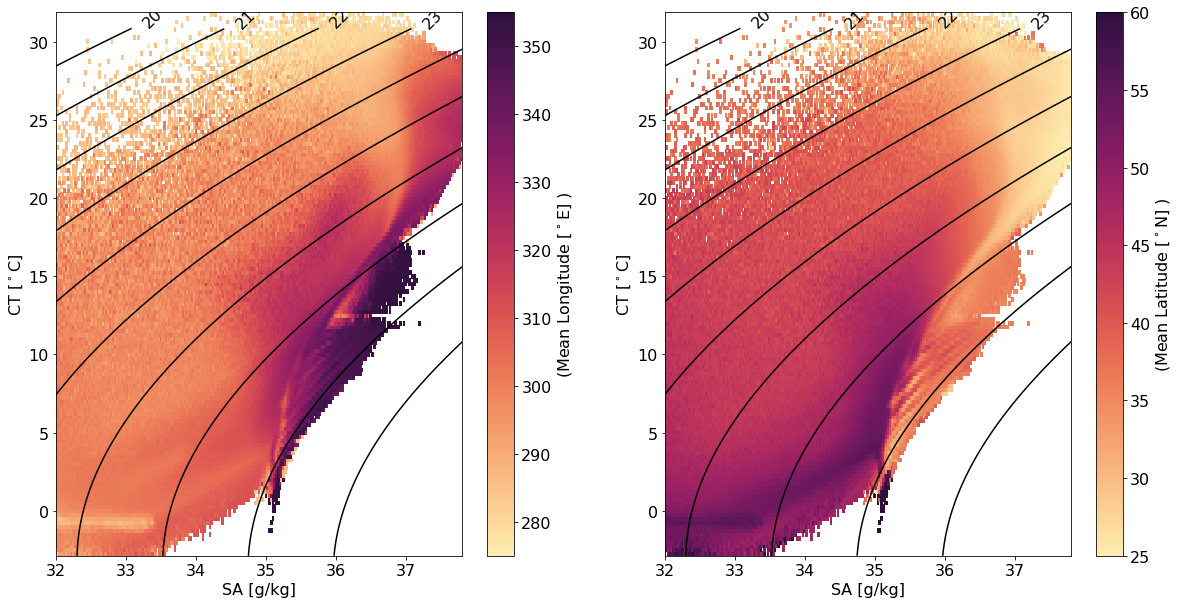

In [11]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

# levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lon, axis=2) ),  vmin=lon_limits[0], vmax=lon_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lat, axis=2) ),  vmin=lat_limits[0], vmax=lat_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('(Mean Longitude [$^\circ$E] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('(Mean Latitude [$^\circ$N] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_lon_lat.png'), dpi=300, bbox_inches='tight')


/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5,0,'SA [g/kg]')

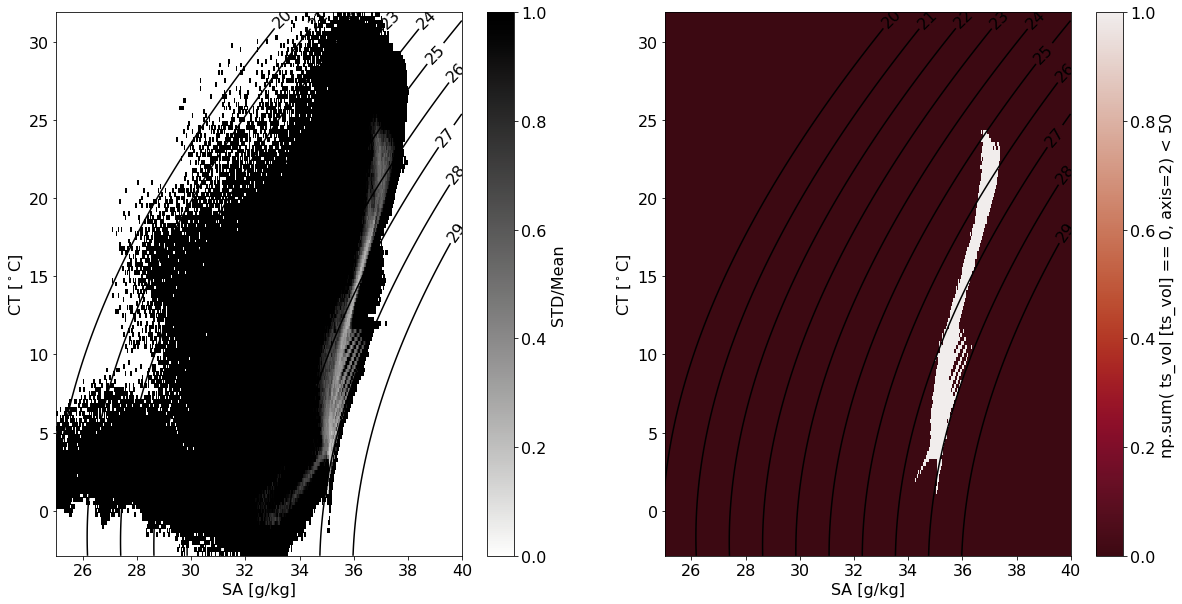

In [12]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (0, 1)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, np.nanstd(ts_vol_zero, axis=2) / np.nanmean(ts_vol_zero, axis=2) ,  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

# c_lim = (0, np.shape(ts_vol['ts_vol'])[2])
cut_off = 10

CS2 = ax2.pcolormesh(S_bini, T_bini, np.sum(ts_vol['ts_vol']==0, axis=2)<cut_off,  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.amp_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('STD/Mean')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('np.sum( ts_vol [''ts_vol''] == 0, axis=2) < 50')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')


### Plot the distribution of volume time-series
Hoping to see if there are characteristic modes indicative of coherent water masses</br>
First normalise the volume, i.e. subtract mean and divide by SD</br>
Then bin each time-step into a range of normalised volume</br>
Finally plot as some kind of PDF

In [13]:
def calc_mm_an_3dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], np.shape(Var)[1], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, :, ii - 1] = np.nanmean(Var[:, :, datvec[:, 1] == ii], axis=2)

        Var_mm_an[:, :, datvec[:, 1] == ii] = Var[:, :, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, :, ii - 1], axis=2)

    return (Var_mm, Var_mm_an)

def calc_mm_an_2dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, ii - 1] = np.nanmean(Var[:, datvec[:, 1] == ii], axis=1)

        Var_mm_an[:, datvec[:, 1] == ii] = Var[:, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, ii - 1], axis=1)

    return (Var_mm, Var_mm_an)

## Define GMM analysis functions

### Define the training dataset and normalise the data

In [316]:
def FlattenSmooth(ts_var, time, ts_var_nodata, rmean, calclog):
    
    # Flatten 3D array, remove zeros (interpolating between) and take the log of volume
    ts_var_array = ts_var.copy()
    ts_var_flat = ts_var_array.reshape(np.shape(ts_var_array)[0] * np.shape(ts_var_array)[1], np.shape(ts_var_array)[2])
    ts_var_flat = ts_var_flat[ts_var_nodata.flatten(), :]

    ts_var_flat_no0 = np.zeros(np.shape(ts_var_flat))

    for ii in np.arange(0, np.shape(ts_var_flat)[0]):
        ts_timeseries = ts_var_flat[ii, :][ts_var_flat[ii, :] != 0]
        dats = time[ts_var_flat[ii, :] != 0]

        ts_var_flat_no0[ii, :] = np.interp(time, dats, ts_timeseries)

    ########################
    
    if rmean:
        # Caculate running mean

        da = xr.DataArray(ts_var_flat_no0,
                         dims=('x', 'time'),
                         coords={'time': dset.time})

        r = da.rolling(time=n_months, center=True)
        r_mean = r.mean().dropna('time')

        ts_var_flat_no0_smth = r_mean.data              
        ts_var_time = mdates.date2num(r_mean['time'])
        
        if calclog:
            ts_var_flat_no0_log = np.log10(ts_var_flat_no0_smth)
        else:
            ts_var_flat_no0_log = ts_var_flat_no0_smth       
        
    else:

        # Don't calculate running mean

        if calclog:
            ts_var_flat_no0_log = np.log10(ts_var_flat_no0)
        else:
            ts_var_flat_no0_log = ts_var_flat_no0     
        
        ts_var_time = time
     
    return ts_var_flat_no0_log, ts_var_time, ts_var_flat_no0
    ########################

def NormVar(ts_var_flat_no0_log, select, norm_type):
    
    if norm_type == 'ts':
        # Try using sklearn.preprocessing, fit calculates the mean and std, and transform standardises

        ts_var_train = ts_var_flat_no0_log[select, :]

        stand = preprocessing.StandardScaler()
        stand.fit(ts_var_train)
        ts_var_norm = stand.transform(ts_var_train) # Training dataset
        ts_var_norm_full = stand.transform(ts_var_flat_no0_log) # Full dataset

    ########################
    
    elif norm_type == 'time':
        # After chatting with G. Maze he suggested normalising in time, it looked like the GMM was selecting by volume
        # Try this here...
        # Caveat can only calculate statistics on the whole dataset and then select the training dataset

        ts_var_mean = np.expand_dims(np.nanmean(ts_var_flat_no0_log, axis=1), axis=1)
        ts_var_std = np.expand_dims(np.nanstd(ts_var_flat_no0_log, axis=1), axis=1)

        ts_var_norm_full = (ts_var_flat_no0_log - ts_var_mean) / ts_var_std

        ts_var_norm = ts_var_norm_full[select, :]

    return ts_var_norm_full, ts_var_norm
    ########################
    
    
def pre_GMM(*args, **kwargs):

    ########################
    # pre_GMM(ts_var, time, dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, WeightVar, rmean=True,  plot=True, norm_type='ts', calclog=True, weightit=True, norm_type_weight='ts')
    ########################
    
    ts_var = args[0]
    time = args[1]
    dep_cut_off = args[2]
    n_data_cut_off = args[3]
    tr_dset_frac = args[4]
    fig_dir = args[5]
    gmm_var_name = args[6]
    
    rmean = kwargs['rmean']
    weightit = kwargs['weightit']
    
    if rmean & weightit:
        n_months = args[7]
        WeightVar = args[8]
        norm_type_weight=kwargs['norm_type_weight']
    elif rmean & ~weightit: 
        n_months = args[7]
    elif ~rmean & weightit: 
        WeightVar = args[7]
        norm_type_weight=kwargs['norm_type_weight']
        
    plot = kwargs['plot']
    norm_type = kwargs['norm_type']
    calclog = kwargs['calclog']
    
    ########################

    # Select TS bins with mean depth that is within a certain range 

    ts_dep_cut_idx = (np.nanmean(ts_dep, axis=2) > dep_cut_off[0]) & (np.nanmean(ts_dep, axis=2) < dep_cut_off[1])

    ########################

    # Select the depth layer(s) here and...
    # Only select T/S bins that have a volume for a set fraction of the time-series given by "cut_off"

    ts_var_nodata = (np.sum(ts_var==0, axis=2) / len(time) < n_data_cut_off) & ts_dep_cut_idx

    ########################
    
    # Flatten and smooth the data if specified
    ts_var_flat_no0_log, ts_var_time, ts_var_flat_no0 = FlattenSmooth(ts_var, time, ts_var_nodata, rmean, calclog)
    
    if weightit:
        ts_weight_flat_no0_log, ts_var_time, ts_weight_flat_no0 = FlattenSmooth(WeightVar, time, ts_var_nodata, rmean, False)
    
    # Select a subsample of the full dataset to calculate mean and std
    # Apparently you need to standardise the training dataset and use 
    # these statistics to standardise the full dataset.

    conc = np.int(np.floor(np.shape(ts_var_flat_no0_log)[0] * tr_dset_frac))
    select = np.random.randint(np.shape(ts_var_flat_no0_log)[0], size=conc)

    ########################

    # Normalise the data and apply weight
    ts_var_norm_full, ts_var_norm = NormVar(ts_var_flat_no0_log, select, norm_type)
    
    if weightit:
        ts_weight_norm_full, ts_weight_norm = NormVar(ts_weight_flat_no0_log, select, norm_type_weight)
        ts_var_norm_full = ts_var_norm_full + np.expand_dims(np.nanmean(ts_weight_norm_full, axis=1), axis=1)
        ts_var_norm = ts_var_norm + np.expand_dims(np.nanmean(ts_weight_norm, axis=1), axis=1)
#         ts_var_norm_full = ts_var_norm_full + ts_weight_norm_full
#         ts_var_norm = ts_var_norm + ts_weight_norm
        
    # Bin to display the PDF of data
    anom_bin = 500
    ts_var_pdf_t = np.zeros((anom_bin, np.shape(ts_var_norm)[1]))

    for ii in np.arange(0, np.shape(ts_var_norm)[1]):

        out = np.histogram(ts_var_norm[:, ii], bins=anom_bin)
        ts_var_pdf_t[:, ii] = out[0]

    amon_bin_mid = out[1]
    
    ########################
    
    if plot:
    
        fig = plt.figure(figsize=(15, 10))
        gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[0.7,1])

        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])

        for ii in np.arange(0, np.shape(ts_var_norm)[0], 1):
            ax1.plot(ts_var_time, ts_var_norm[ii, :], color=[0.5, 0.5, 0.5], linewidth=0.1)

        c_lim = (0, 10)
        cs = ax2.pcolormesh(ts_var_time, amon_bin_mid, (ts_var_pdf_t), cmap=cmocean.cm.amp, vmin=c_lim[0], vmax=c_lim[1])
                # ax.set_yscale('log')
                # ax.set_ylim(1e-2, 1e16)
        cbar = fig.colorbar(cs, orientation='horizontal', shrink=0.7)
        
        if rmean:
            ax1.set_title('EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(dep_cut_off[0], dep_cut_off[1], n_months))
            outfile = os.path.expanduser(fig_dir + 'EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(dep_cut_off[0], dep_cut_off[1], n_months)
        else:
            ax1.set_title('EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}_rmean'.format(dep_cut_off[0], dep_cut_off[1]))
            outfile = os.path.expanduser(fig_dir + 'EN4_' + gmm_var_name + '_norm_dep{:1.0f}_{:1.0f}.png').format(dep_cut_off[0], dep_cut_off[1])
                
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    for_gmm = None
    
    if rmean:    
        for_gmm = \
        {'full_dataset': ts_var_norm_full.copy(), 'training_dataset': ts_var_norm.copy(), 'unproc_dataset':ts_var_flat_no0.copy(), 'time': ts_var_time.copy(), 'unproc_time': time, \
         'no_data': ts_var_nodata.copy(), 'dep_cut_off': dep_cut_off.copy(), 'rmean': True, 'n_months': n_months, 'gmm_var_name': gmm_var_name}
    else:                                     
        for_gmm = \
        {'full_dataset': ts_var_norm_full.copy(), 'training_dataset': ts_var_norm.copy(), 'unproc_dataset':ts_var_flat_no0.copy(), 'time': ts_var_time.copy(), 'unproc_time': time, \
         'no_data': ts_var_nodata.copy(), 'dep_cut_off': dep_cut_off.copy(), 'rmean': False, 'gmm_var_name': gmm_var_name}

    return for_gmm


### Use BIC to select the best number of classes

In [309]:
import itertools

def run_BIC(for_gmm, fig_dir):
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 18)
    cv_types = ['spherical', 'tied', 'diag', 'full']

    gmm = None

    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, tol = 1e-6, max_iter = 500, n_init=20)
            gmm.fit(for_gmm['training_dataset'])
            bic.append(gmm.bic(for_gmm['training_dataset']))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(10, 5))
    spl = plt.subplot()
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    
    if for_gmm['rmean']:
        plt.title('BIC score per model ' + for_gmm['gmm_var_name'] + ' dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('BIC score per model ' + for_gmm['gmm_var_name'] + ' dep{:1.0f}_{:1.0f}'.format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_BIC_' + for_gmm['gmm_var_name'] + '_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_BIC_' + for_gmm['gmm_var_name'] + '_dep{:1.0f}_{:1.0f}.png').format(for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### Define GMM classes with the training dataset

In [291]:
def gmm_fit(for_gmm, n_comp, plot_col, fig_dir):

    cov_type = 'full'  # covariance type (full, tied, diag, or spherical)

    gmm = None
    gmm = mixture.GaussianMixture(n_components= n_comp, \
                                      covariance_type = cov_type, tol = 1e-6, max_iter = 500, n_init=20)

    gmm.fit(for_gmm['training_dataset'])

    weights = np.squeeze(gmm.weights_)  # shape (n_components)
    # note: "weights" is the same for each col_red
    means = np.squeeze(gmm.means_)  # shape (n_components, n_features)
    covariances = abs(np.squeeze(gmm.covariances_))  # shape (n_components, n_features) 

    fig, ax = plt.subplots(figsize=(15, 10))

    for ii in np.arange(0, np.shape(for_gmm['training_dataset'])[0], 1):
    #     ax.plot(ts_vol['time'], ts_vol_norm[ii, :], color=[0.25, 0.25, 0.25], linewidth=0.1)
        ax.plot(for_gmm['time'], for_gmm['training_dataset'][ii, :], color=[0.25, 0.25, 0.25], linewidth=0.1)

    for ii in np.arange(0, n_comp, 1):
    #     ax.plot(ts_vol['time'], means[ii, :], color=plot_col[ii])
        ax.plot(for_gmm['time'], means[ii, :], color=plot_col[ii])

    if for_gmm['rmean']:
        plt.title('GMM classes ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('GMM classes ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    ax.set_facecolor('lightgray')
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_GMM_' + for_gmm['gmm_var_name'] + '_tr_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_GMM_' + for_gmm['gmm_var_name'] + '_tr_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    return gmm

### Label and plot the TS-Classes

In [347]:
def gmm_label(gmm, for_gmm, plot_col, fig_dir):

    labels = gmm.predict(for_gmm['full_dataset'])
    post_prob = gmm.predict_proba(for_gmm['full_dataset'])

    post_prob_class = np.nanmax(post_prob, axis=1)

    S_g, T_g = np.meshgrid(S_bini, T_bini)
    S_label_index = S_g[for_gmm['no_data']]
    T_label_index = T_g[for_gmm['no_data']]

    c_lim = (10.5, 14.5)
    levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.subplots()

    CS1 = ax1.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
    CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
    ax1.clabel(CS_dens, fmt='%2.0f')

    cbar = fig.colorbar(CS1, ax=ax1)
    cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

    ax1.set_ylabel('CT [$^\circ$C]')

    ax1.set_xlabel('SA [g/kg]')

    ax1.set_xlim((32, 37.8))

    if for_gmm['rmean']:
        plt.title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        plt.title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
    
    mean_class_T = np.zeros((n_comp, 1))
    mean_class_S = np.zeros((n_comp, 1))
    std_class_T = np.zeros((n_comp, 1))
    std_class_S = np.zeros((n_comp, 1))
    
    for ii in np.unique(labels):
        ax1.scatter(S_label_index[labels == ii], T_label_index[labels == ii], s = 20, c = plot_col[ii])
        mean_class_T[ii] = np.nanmean(T_label_index[labels == ii])
        mean_class_S[ii] = np.nanmean(S_label_index[labels == ii])
        std_class_T[ii] = np.nanstd(T_label_index[labels == ii])
        std_class_S[ii] = np.nanstd(S_label_index[labels == ii])
    
    class_TS_stat = {'mean_class_T': mean_class_T.copy(), 'mean_class_S': mean_class_S.copy(), 'std_class_T': std_class_T.copy(), 'std_class_S': std_class_S.copy()}
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes1_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes1_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    ########################

    ts_dep_flat = np.nanmean(ts_dep, axis=2)[for_gmm['no_data']]

    c_lim = (10.5, 14.5)
    levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
    fig = plt.figure(figsize=(20, 20))

#     ax = fig.subplots(4, 4, sharex='col', sharey='row',
#                             gridspec_kw={'hspace': 0, 'wspace': 0})

    for ii in np.arange(0, n_comp, 1):

        ax = fig.add_subplot(4, 4, ii+1)
        
        if ii==0:
            if for_gmm['rmean']:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
        ax.set_xlim((32, 37.8))
        ax.set_ylim((-3, 33))

        ax.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
        CS_dens = ax.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
        ax.clabel(CS_dens, fmt='%2.0f')

        if (ii == 0) | (ii == 4):
            ax.set_ylabel('CT [$^\circ$C]')

        if ii > 3:
            ax.set_xlabel('SA [g/kg]')

    #     CS1 = ax.flatten()[ii].scatter(S_label_index[labels == ii], T_label_index[labels == ii], c = post_prob_class[labels == ii], s = 25)
        CS1 = ax.scatter(S_label_index[labels == ii], T_label_index[labels == ii], c = plot_col[ii], s = ts_dep_flat[labels == ii]/10)
    #     cbar = fig.colorbar(CS1, ax=ax[ii])
    #     cbar.ax.set_ylabel('Probability')

    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes2_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes2_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
                
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    ########################

    fig = plt.figure(figsize=(20, 18), constrained_layout=False)
    
    # ax = fig.subplots(2, 4, sharex='col', sharey='row',
    #                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())
    # ax = fig.add_subplot(2, 4, sharex='col', sharey='row',
    #                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())


    for ii in np.arange(0, n_comp, 1):

        ax = fig.add_subplot(4, 4, ii+1, projection=ccrs.PlateCarree())
 
        if ii==0:
            if for_gmm['rmean']:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax.set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
        ax.set_extent([lon_limits[0], lon_limits[1], lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())
        ax.stock_img()
        ax.coastlines()

        class_S = S_label_index[labels == ii]
        class_T = T_label_index[labels== ii]

        for jj in np.arange(0, len(class_S), 4): # Skipping some data to speed up plotting

            ts_idx = np.where((S_g == class_S[jj]) & (T_g == class_T[jj]))

            ax.scatter(ts_lon[ts_idx[0], ts_idx[1], :], ts_lat[ts_idx[0], ts_idx[1], :], s = ts_dep[ts_idx[0], ts_idx[1], :]/10, c = plot_col[ii], edgecolor='k')
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes_map_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(n_comp, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_classes_map_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(n_comp, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

    
    return labels, class_TS_stat

### Plot TS class time-series for variable that went through GMM

In [293]:
def plot_class_timeseries(gmm, labels, for_gmm, plot_col, fig_dir):
    
    means = np.squeeze(gmm.means_)
    
    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1, sharex='col', gridspec_kw={'hspace': 0})

    fig.text(0.09, 0.5, 'Normalised log$_{10}$(CT - SA volume)', ha='center', va='center', rotation='vertical')

    for ii in np.arange(0, gmm.n_components, 1):

        dat_ind = np.nonzero(labels == ii)[0]

        for jj in np.arange(0, len(dat_ind), 1):

            ax[ii].plot(for_gmm['time'], for_gmm['full_dataset'][dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)

        ax[ii].plot(for_gmm['time'], means[ii, :], color=plot_col[ii], linewidth=3)
    #     ax[ii].set_facecolor('lightgray')

        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(for_gmm['time']), np.max(for_gmm['time'])))
        ax[ii].set_ylim((-2.5, 4.2))
        ax[ii].grid(True)
    
    if for_gmm['rmean']:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1)

    for ii in np.arange(0, gmm.n_components, 1):

        dat_ind = np.nonzero(labels == ii)[0]
        class_vol = np.zeros((len(dat_ind), len(for_gmm['unproc_time'])))

        for jj in np.arange(0, len(dat_ind), 1):

            class_vol[jj, :] = for_gmm['unproc_dataset'][dat_ind[jj], :]
            ax[ii].plot(for_gmm['unproc_time'], for_gmm['unproc_dataset'][dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)

        ax[ii].semilogy(for_gmm['unproc_time'], np.mean(class_vol, axis=0), color=plot_col[ii])

        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(for_gmm['unproc_time']), np.max(for_gmm['unproc_time'])))
        ax[ii].set_ylim((5e10, 1e16))
        ax[ii].grid(True)
    #     ax[ii].set_facecolor('lightgray')
    if for_gmm['rmean']:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
    else:
        ax[0].set_title('EN4 ' + for_gmm['gmm_var_name'] + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))
        
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_log_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components, for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1],\
        for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_' + for_gmm['gmm_var_name'] + '_TS_class_log_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components, for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')



### Plot TS class time-series of any variable

In [333]:
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

def plot_ts_class_var_timeseries(gmm, labels, for_gmm, Var, time, class_col, line_col, yax_scale, fig_title, fig_dir):

    gmm_var_name = for_gmm['gmm_var_name']
    
    S_g, T_g = np.meshgrid(S_bini, T_bini)
    S_label_index = S_g[for_gmm['no_data']]
    T_label_index = T_g[for_gmm['no_data']]

    fig = plt.figure(figsize=(15, 20))
    ax = fig.subplots(gmm.n_components, 1)


    if type(line_col) == matplotlib.colors.LinearSegmentedColormap:

        COL = MplColorHelper(line_col, 0, 25)
    
    mean_Var_all_classes = np.zeros((gmm.n_components, len(time)))
    
    for ii in np.arange(0, gmm.n_components, 1):

        if ii==0:
            if for_gmm['rmean']:
                ax[ii].set_title('EN4 GMM: ' + gmm_var_name + ' Var: ' + fig_title + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months'.format(gmm.n_components,\
                for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1], for_gmm['n_months']))
            else:
                ax[ii].set_title('EN4 GMM: ' + gmm_var_name + ' Var: ' + fig_title + ' nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}'.format(gmm.n_components,\
                                                                                                                                   for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1]))

        class_S = S_label_index[labels == ii]
        class_T = T_label_index[labels == ii]

        dat_ind = np.nonzero(labels == ii)[0]
        class_Var = np.zeros((len(dat_ind), len(time)))

        for jj in np.arange(0, len(class_S), 1):

            ts_idx = np.where((S_g == class_S[jj]) & (T_g == class_T[jj]))

            class_Var[jj, :] = Var[ts_idx[0], ts_idx[1], :].flatten()

            if type(line_col) == matplotlib.colors.LinearSegmentedColormap:
                ax[ii].plot(time, class_Var[jj, :], c=COL.get_rgb(class_T[jj]), linewidth=0.1)
            elif type(line_col) == list:
                ax[ii].plot(time, class_Var[jj, :], c=line_col, linewidth=0.5)

        if yax_scale == 'log':
            ax[ii].semilogy(time, np.nanmean(class_Var, axis=0), color=class_col[ii], linewidth=5)
        elif yax_scale == 'linear':
            ax[ii].plot(time, np.nanmean(class_Var, axis=0), color=class_col[ii], linewidth=5)
                
        loc = mdates.AutoDateLocator()
        tick_format = mdates.AutoDateFormatter(loc)
        ax[ii].xaxis.set_major_locator(loc)
        ax[ii].xaxis.set_major_formatter(tick_format)

        ax[ii].set_xlim((np.min(time), np.max(time)))
    #     ax[ii].set_ylim((5e10, 1e16))
        ax[ii].grid(True)
        #     ax[ii].set_facecolor('lightgray')ax[ii].plot

        mean_Var_all_classes[ii, :] = np.nanmean(class_Var, axis=0)
    
    if for_gmm['rmean']:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_gmm_' + gmm_var_name + '_var_' + fig_title + '_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}_rmean_{:1.0f}_months.png').format(gmm.n_components,\
        for_gmm['dep_cut_off'][0],for_gmm['dep_cut_off'][1], for_gmm['n_months'])
    else:
        outfile = \
        os.path.expanduser(fig_dir + 'EN4_gmm_' + gmm_var_name + '_var_' + fig_title + '_timeseries_nclasses_{:1.0f}_dep{:1.0f}_{:1.0f}.png').format(gmm.n_components,\
                                                                                                                                                     for_gmm['dep_cut_off'][0], for_gmm['dep_cut_off'][1])
        
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    
    return mean_Var_all_classes

## Run everything...

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in greater
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10


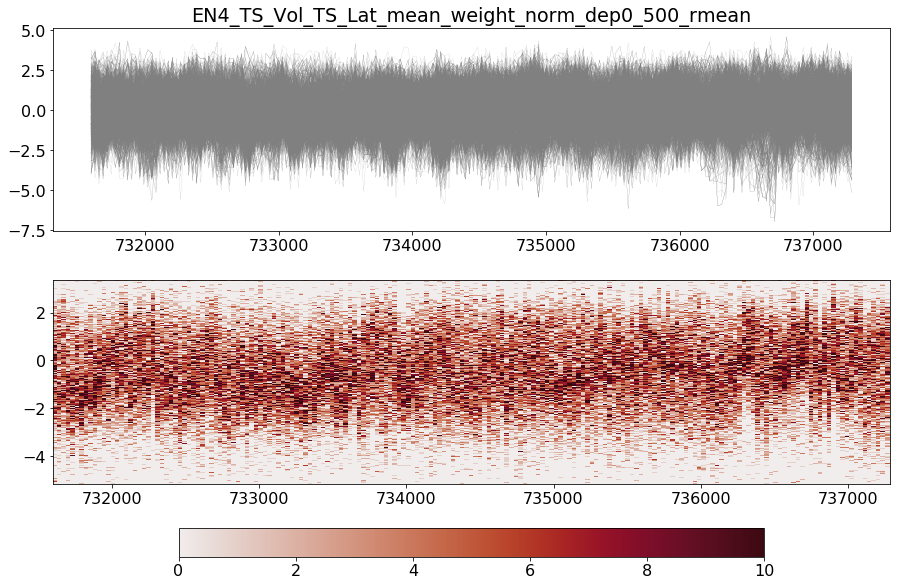

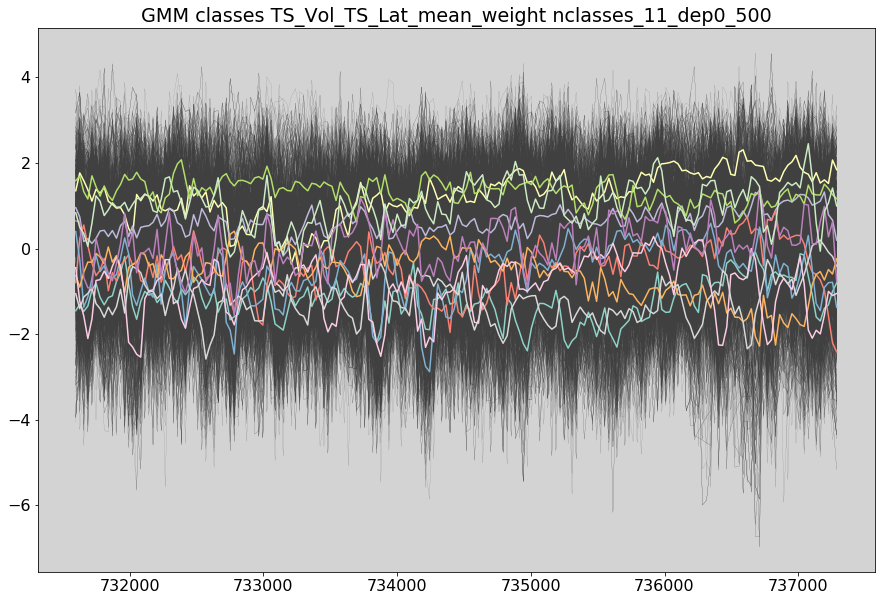

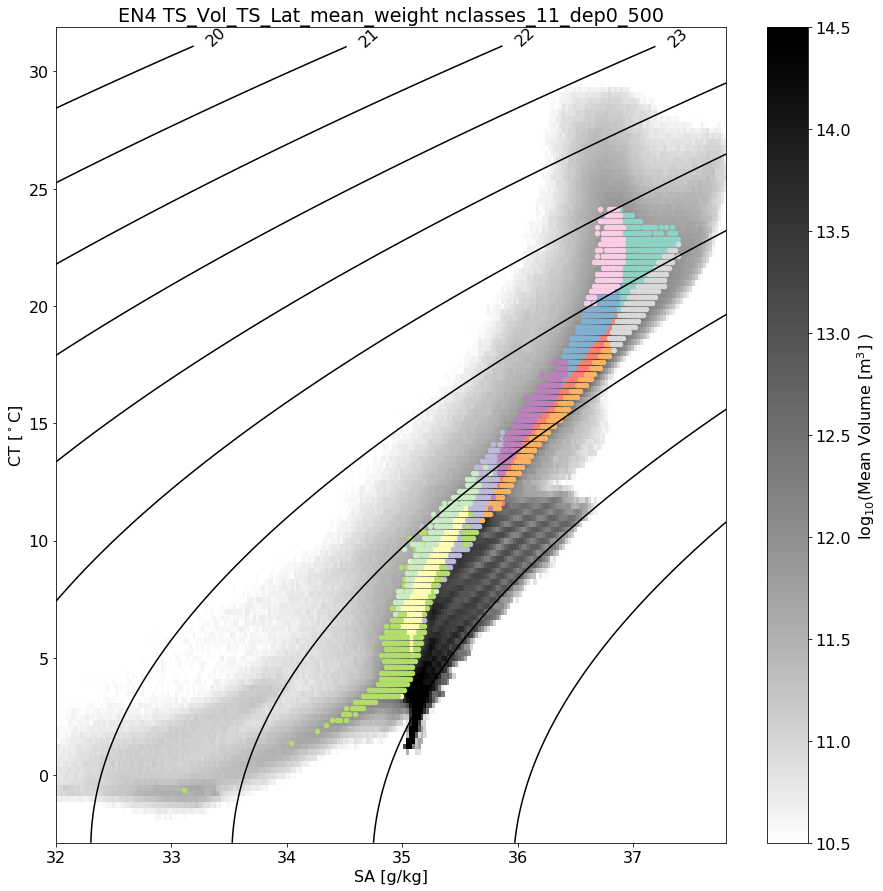

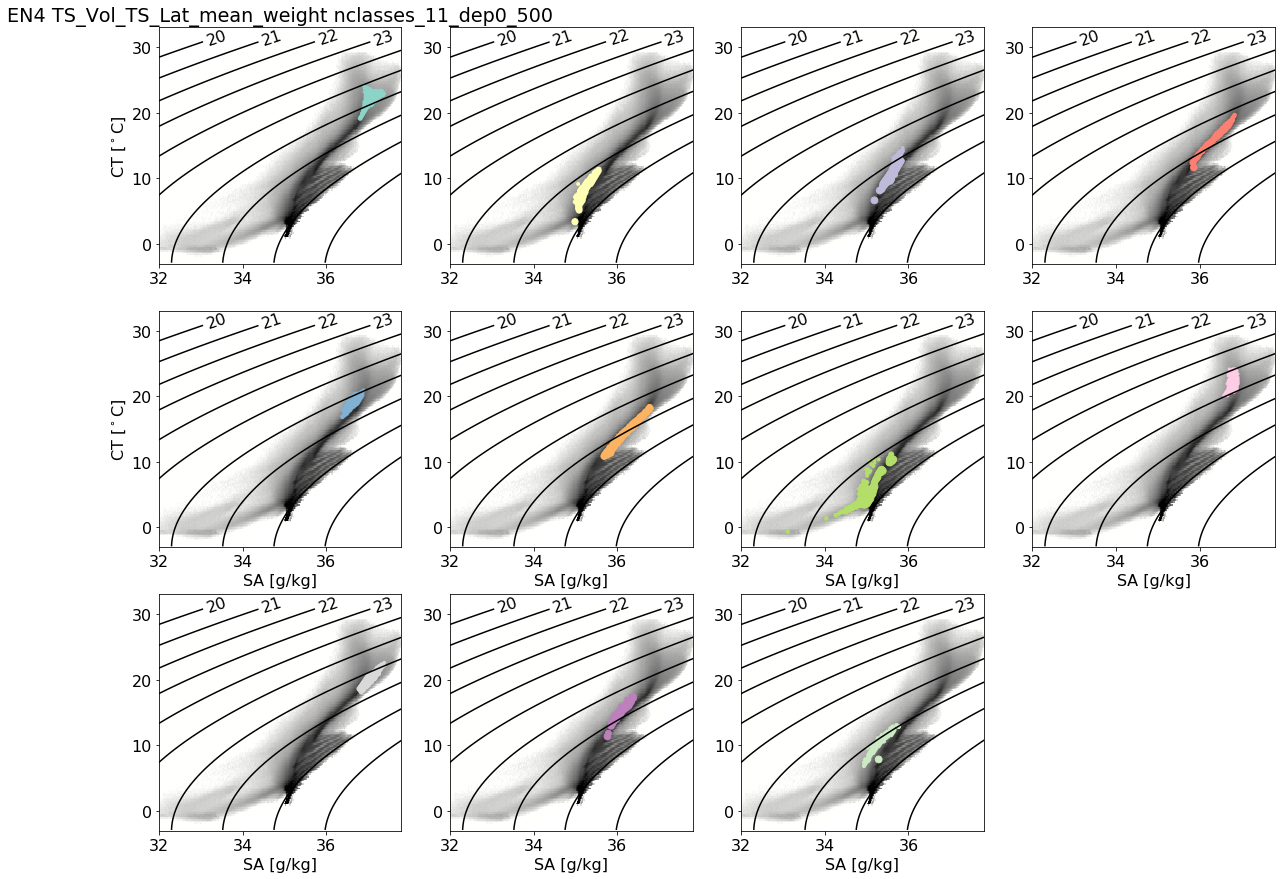

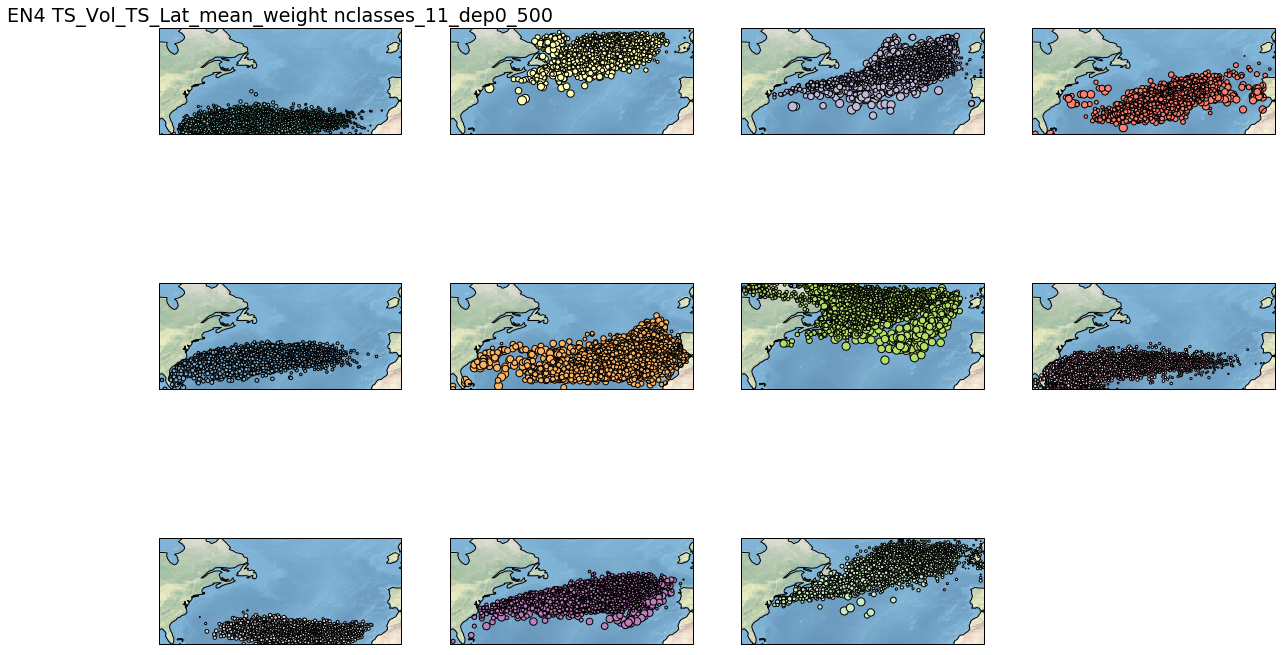

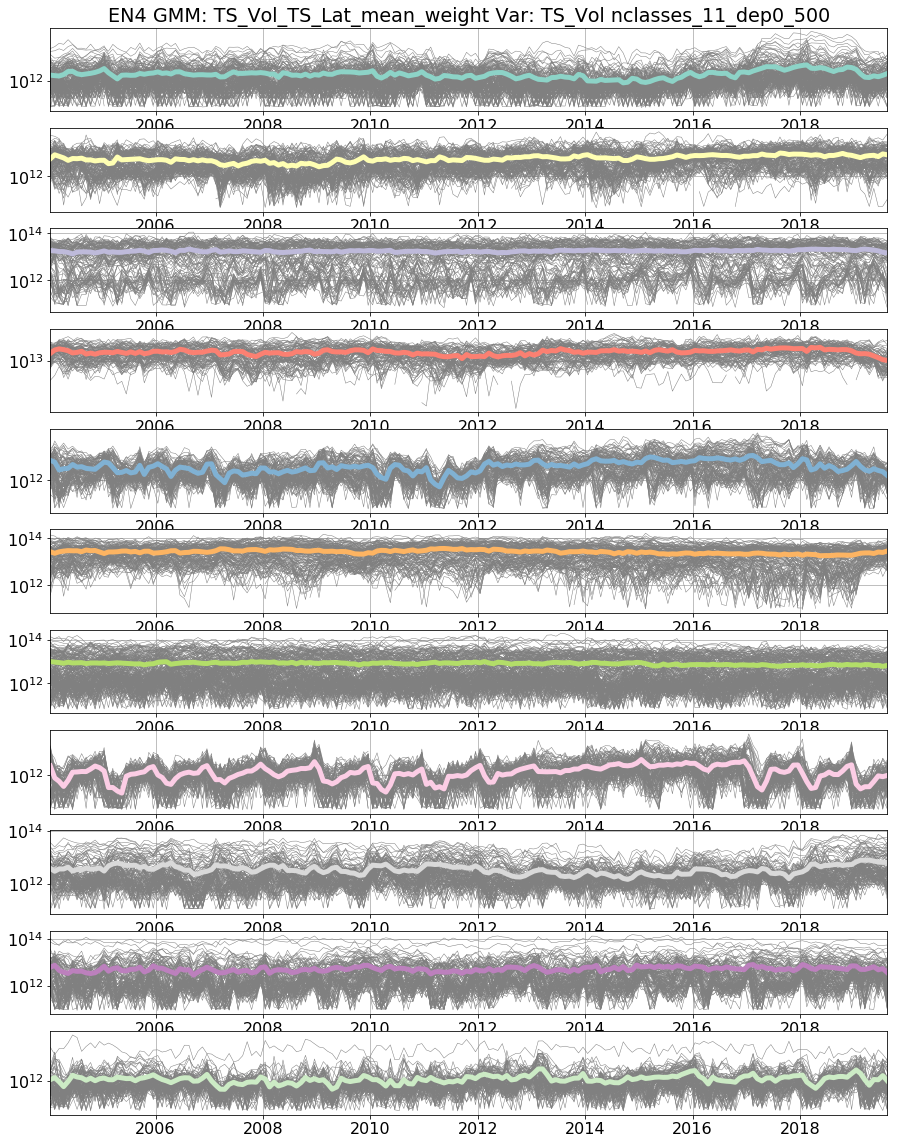

In [390]:
dep_cut_off = [0, 500] # Select depth range
n_data_cut_off = 10 / len(ts_vol['time']) # Select no data cut-off
n_months = 4 # Running mean window size
tr_dset_frac = 1 # Training dataset size: Fraction of full dataset

fig_dir = '~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/'

#### Just TS VOL ####
# ts_var = ts_vol['ts_vol'] # 4 month running mean, 10 classes, norm_type='time', calclog='True'
# gmm_var_name = 'TS_Vol'
# # for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='time', calclog=True, weightit=False)
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, rmean=False,  plot=True, norm_type='time', calclog=True, weightit=False)

#### TS VOL weighted with TS LAT ####
ts_var = ts_vol['ts_vol'] # 4 month running mean, 10 classes, norm_type='time', calclog='True'
WeightVar = ts_lat.copy()
WeightVar[np.isnan(WeightVar)] = 0
gmm_var_name = 'TS_Vol_TS_Lat_mean_weight'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, WeightVar, rmean=True,  plot=True, norm_type='time', calclog=True, weightit=True, norm_type_weight='ts')
for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, WeightVar, rmean=False,  plot=True, norm_type='time', calclog=True, weightit=True, norm_type_weight='ts')

#### Just TS LAT ####
# ts_var = ts_lat.copy() # 4 month running mean, 10 classes, norm_type='ts', calclog='False'
# ts_var[np.isnan(ts_var)] = 0
# gmm_var_name = 'TS_Lat'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='ts', calclog=False, weightit=False)

#### Just TS LON ####
# ts_var = ts_lon.copy()
# ts_var[np.isnan(ts_var)] = 0
# gmm_var_name = 'TS_Lon'
# for_gmm = pre_GMM(ts_var, ts_vol['time'], dep_cut_off, n_data_cut_off, tr_dset_frac, fig_dir, gmm_var_name, n_months, rmean=True,  plot=True, norm_type='ts', calclog=False, weightit=False)


# run_BIC(for_gmm, fig_dir)
# 0-250 m = 10 classes
# 0-500 m = 11 classes
# 0-1000 m = 13 classes
# 0-6000 m = 15 classes
# 1000-6000 m = 2/3 classes

n_comp = 11 # number of classes in GMM object
plot_col = ('#8dd3c7',
            '#ffffb3',
            '#bebada',
            '#fb8072',
            '#80b1d3',
            '#fdb462',
            '#b3de69',
            '#fccde5',
            '#d9d9d9',
            '#bc80bd',
            '#ccebc5',
            '#ffed6f',
            '#b15928',
            '#33a02c',
            '#e31a1c')

gmm = gmm_fit(for_gmm, n_comp, plot_col, fig_dir)

labels, class_TS_stat = gmm_label(gmm, for_gmm, plot_col, fig_dir)

# plot_class_timeseries(gmm, labels, for_gmm, plot_col, fig_dir)

Var = ts_vol['ts_vol'].copy()
Var[Var == 0] = np.nan

fig_title = 'TS_Vol'
line_col = [0.5, 0.5, 0.5] 
# line_col = cmocean.cm.thermal
yax_scale = 'log'

mean_vol_all_classes = plot_ts_class_var_timeseries(gmm, labels, for_gmm, Var, ts_vol['time'], plot_col, line_col, yax_scale, fig_title, fig_dir)

In [381]:
MplColorHelper = None
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

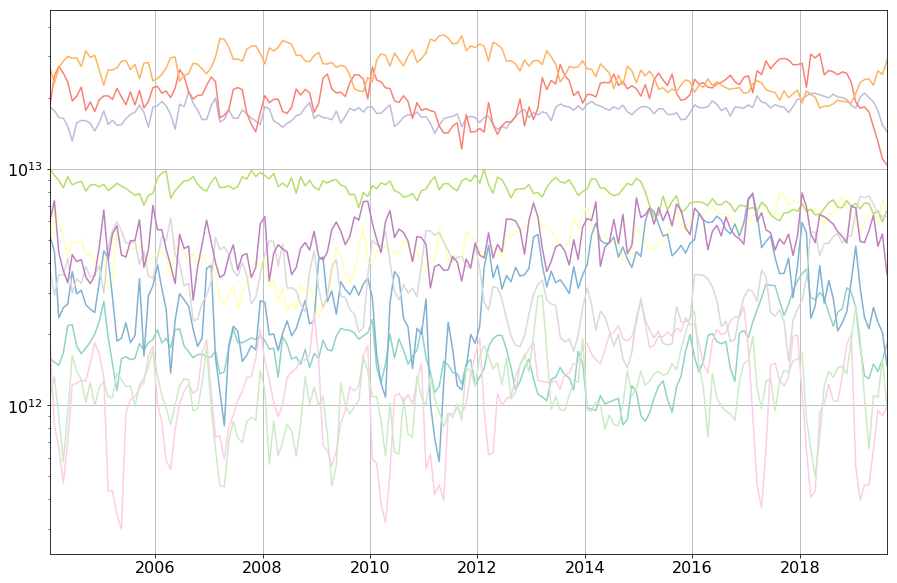

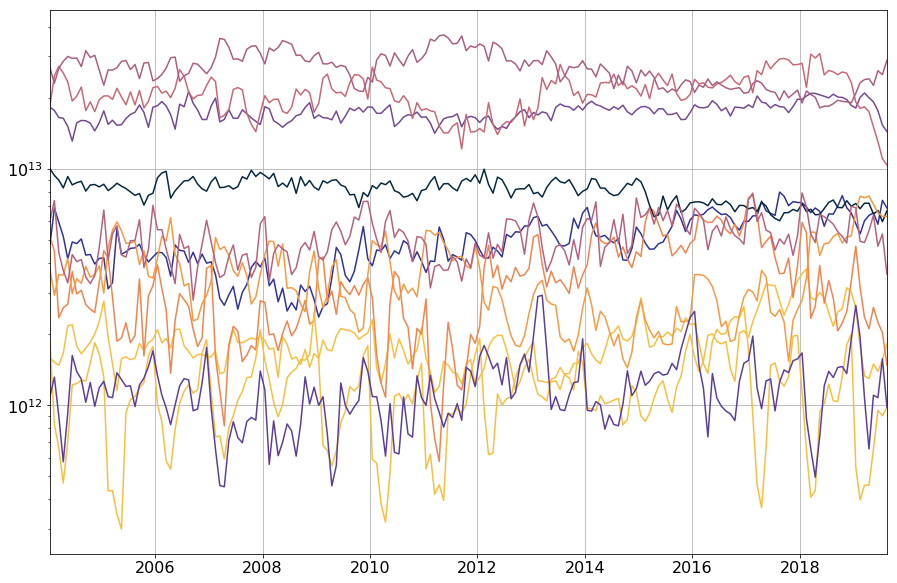

In [391]:
fig, ax = plt.subplots(figsize=(15, 10))

for ii in np.arange(0, np.shape(mean_vol_all_classes)[0], 1):
    ax.semilogy(ts_vol['time'], mean_vol_all_classes[ii, :], c = plot_col[ii])

loc = mdates.AutoDateLocator()
tick_format = mdates.AutoDateFormatter(loc)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(tick_format)

ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
ax.grid(True)
##################

COL2 = MplColorHelper(cmocean.cm.thermal, 5, 25)
fig, ax = plt.subplots(figsize=(15, 10))

for ii in np.arange(0, np.shape(mean_vol_all_classes)[0], 1):
    ax.semilogy(ts_vol['time'], mean_vol_all_classes[ii, :], c = COL.get_rgb(class_TS_stat['mean_class_T'][ii,0]))
    
loc = mdates.AutoDateLocator()
tick_format = mdates.AutoDateFormatter(loc)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(tick_format)

ax.set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
ax.grid(True)

In [384]:
class_TS_stat['mean_class_T'][ii][0]

5.340686274509804

## Notes

### Pre-selection of data
Steps - <br/>
1. Remove T/S classes that contain no volume of water for a given fraction of the time-series

Currently if a TS bin is empty for more than 10/236 time-steps then we that class is not considered for the GMM. <br/>
Increasing this fraction leads to the BIC score minimising at a high value at 13/14 of classes, but the resulting clusters <br/>
are less well defined or constrained.<br/>
With no empty T/S bins permitted the BIC score minimises at 5/6 but the number of TS classes is quite small,<br/>
10/236 seems to be a good comprimise, giving a good distrubtion of TS classes and well defined clusters

2. For T/S classes that pass step 1. Interpolate between those intervals of no volume
3. Smooth the data 

I've done this provisionally with a 2 month running mean, seems group stuff well provisionally

4. For normalisation, calculate the logarithm of the volume, otherwise the GMM algorithm separates by volume
5. Select a given depth range

#### Notes on step 4.
Justification for step 4 - with all T/S classes the GMM algorithm consistently groups shallow with deep water masses. <br/>
Therefore seemed logical to run the GMM on TS classes within specific depth ranges <br/>
First tried selecting the upper 1000m - Worked OK still some grouping of deep and shallow water masses. <br/>
Next selected the upper 500m - this seems to work pretty well, needed up to ~13~ 10 classes but seemed to group water masses consistently, <br/>
but there was some clustering still of deep with shallow watermasses, that clearly have different variability, but look similar in noramilised space. <br/>
Clustering seems to work best however, when the temporal statistics are used to normalise the log of the volume

### Normalisation of data
Options - <br/>
1. Use sklearn.preprocessing, this calculates the mean and STD of each time-step for normalisation - option 'ts'
2. Use the temporal mean and STD for normalisation - option 'time'
3. Weight the volume timeseries (only 'time' normalised') according to the time-mean of the 'ts' normalised TS latitude

#### Notes on option 1.
The normalised time-series do not sit about zero, with the more voluminous TS classes sitting way above zero. <br/>
As a result the GMM algorithm selects by volume and the distribution of classes reflects the volumetric distribution.

#### Notes on option 2.
All volume time-series sit about zero in this case. However, the GMM algorithm often grouped shallow with deep water masses that were close in normalised space, <br/>
but separate in real space. Therefore, it seemed logical to try clustering different depth levels (see notes above)

#### Notes on option 3.
This allows the separation of TS volume time-series in normalised space. Can use the time variable 'ts' normalised TS latitude, but some of the variability of TS latitude <br/>
is then imparted onto the variability of volume and this affects the eventual classes.

### Selection of training dataset
Initially I selected around 25% of the dataset to pass to the GMM algorithm, but have recently been giving the algorithm the whole dataset as it doesn't seem to take <br/>
a huge amount of time to run. <br/>
<br/>
The way in which I select the training dataset shuffles the order of the flattened array of volume time-series. If I use the same shuffled array to train and predict <br/>
with the GMM object, I get nonsense. Also if I run BIC on the un-shuffled data, it does not minimise at a sensible number of classes. <br/>
I can however use the un-shuffled data for training and predicting without an issue...


### GMM
Options - <br/>

1. Number of classes

This seems to vary by the chosen depth range. I have been selecting the number of classes by looking at the time-series of volume in each class <br/>
For 0-500m - Used BIC example from the GMM doc, a class number range of 7-10 seems to typically score the lowest - settle with 10

2. Covariance type - full, tied, diag, or spherical

Looking at the results from the BIC analysis it seems that full covariance type is most suitable

3. Max tolerance

I've tried changing the max tolerence without much luck, in other words it doesn't seem to make much of a difference. Not sure why this is the case

4. Max number of iterations

I've upped this to 500, default is 100. Seems to stop after 1 or 2 iterations according to gmm.n_iter_

#### Notes on the probabilities output by the GMM class
So far the probabilities are always 1. Is that right? <br/>


## Applying GMM to different variables
The GMM can be applied to time-series of TS latitude, longitude or depth. They each have fairly unique variability for given water masses. <br/>
TS latitude is most interesting it seems to group water masses very clearly especially if you use 'ts' normalisation. <br/>
This provides some potential application for weighting the volume time-series to separate watermass that are routinely grouped together. 


## Plan for coming days
Why are the probabilities always 1? Why does the model converge so quickly? Can we use the mean of multiple GMM runs to get more confidence in the clusters?